# Football Transfer Market Data Analysis

This notebook is based on the 'Football Data from Transfermarkt Football (Soccer) data' on Kaggle, scraped from Transfermarkt website.

The notebook was created in March 2023, by David Coxon, with the purpose of learning to exploring sports data in a team sport. (I have previously worked with sports data in running and climbing).

If you find this notebook useful please upvote it, if you have any comments on the effectiveness of the visualisationd or how I could have achieved a better result please feel free to post comments. Also please check out the credits at the bottom for detail of other notebooks that I found helpful.

In [3]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
import datetime
from datetime import datetime, timedelta, date
import warnings
import os

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#settings
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 1200)
pd.set_option('display.width', 1200)
warnings.filterwarnings("ignore")
%matplotlib inline

#variables
colour=['maroon','r','g','darkgreen','c','teal','b','navy','indigo','m','deeppink','orange','sienna','yellow','khaki','olive','tan','black','grey','brown']

print("Packages installed")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Packages installed


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from keras.layers import Input, Dense, LSTM,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model
import tensorflow as tf
# from arch import arch_model
import sys
# from attention_utils import get_activations
# from keras.layers import merge
from keras.layers.core import *
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.models import *
import os
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math
import warnings
warnings.filterwarnings("ignore")
# from common.utils import load_data, mape
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
# from pyGRNN import GRNN
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

# Get Data

In [5]:
dataframes=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file=filename.split('.')
        file=((file[0]+"_df"))
        if file !="_df":
            filepath=os.path.join(dirname,filename)
            df=pd.read_csv(filepath,sep=",",encoding = "UTF-8")
            exec(f'{file} = df.copy()')
            print(file, df.shape)
            dataframes.append(df)
print('Data imported')

players_df (28461, 23)
competitions_df (43, 10)
games_df (58900, 21)
game_events_df (530401, 7)
club_games_df (117800, 11)
player_valuations_df (424323, 9)
appearances_df (1173126, 13)
clubs_df (411, 16)
Data imported


# Process Data

In [6]:
# Calculate the age of each player
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
# drop players with no date of birth
players_df = players_df[players_df['date_of_birth'].isnull() == False]
now = datetime(2022,12,31)
players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round().astype(int) 

# Calculate the contract remaining of each player
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
# drop players with no date of birth
players_df = players_df[players_df['contract_expiration_date'].isnull() == False]
now = datetime(2022,12,31)
players_df['term_days_remaining'] = (players_df['contract_expiration_date']- now).apply(lambda x: x.days) 

# add year to player valuations
player_valuations_df['datetime']=pd.to_datetime(player_valuations_df['datetime'], format="%Y-%m-%d")
player_valuations_df['year']=player_valuations_df['datetime'].dt.year

# add year to player appearances
appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
appearances_df['year']=appearances_df['datetime'].dt.year

#add position to player valuations
position_df=players_df.copy()
position_df=position_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'market_value_in_eur', 'highest_market_value_in_eur', 'agent_name', 'contract_expiration_date', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'image_url', 'last_season', 'url', 'age'], axis=1)
player_valuations_df=player_valuations_df.merge(position_df, left_on='player_id', right_on='player_id')

#add position to appearances
value_df=players_df.copy()
value_df=value_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'sub_position', 'highest_market_value_in_eur', 'agent_name', 'contract_expiration_date', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'image_url', 'last_season', 'url', 'age'], axis=1)
appearances_df1=value_df.merge(appearances_df, left_on='player_id', right_on='player_id')

print("Data processing complete")

Data processing complete


# Collating All Player Data

Having look at each the data in each of the data files, I'm going to pull all of the data together for each player, so that we can look at feature importance and start to model transfer values.

In [7]:
# This was by attempt to collate all of the player data, but i found a far more elegant solution from LOIS CORDEIRO see below

#Start with players_df
merged_players_df=players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth','first_name', 'last_name', 'player_code', 'image_url', 'url'], axis=1)

#next look at clubs_df
merged_players_df = merged_players_df.reindex(columns = merged_players_df.columns.tolist() + ['club_value','squad_size','goals','goals_2021','games_2021','assists_2021','minutes_played_2021','goals_against_2021','goals_for_2021','clean_sheet_2021'])
for player_id in merged_players_df.player_id.unique():
    #print(players_df.current_club_id[(players_df.player_id==player_id)])
    club_id= players_df.current_club_id[(players_df.player_id==player_id)]
    #print(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
    #print(clubs_df.squad_size[(clubs_df.club_id==int(club_id))])
    try:
        merged_players_df.club_value[(players_df.player_id==player_id)]=int(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
    except:
        merged_players_df.club_value[(players_df.player_id==player_id)]='NaN'  
    merged_players_df.squad_size[(players_df.player_id==player_id)]=int((clubs_df.squad_size[(clubs_df.club_id==int(club_id))]))
#sort column order
columns=['player_id','games_2021','minutes_played_2021','goals_2021','assists_2021','goals_against_2021','goals_for_2021','clean_sheet_2021','name','position','sub_position','last_season','foot','height_in_cm','age','country_of_citizenship','country_of_birth','current_club_name','club_value','squad_size','current_club_domestic_competition_id','agent_name','contract_expiration_date','term_days_remaining','market_value_in_eur','highest_market_value_in_eur']
merged_players_df=merged_players_df[columns]
#print(merged_players_df.head())

#merge games and appearances
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
print('Player and club data merged');#print(games_and_appearances_df.shape);print(games_and_appearances_df.columns);print(games_and_appearances_df.head(1))

Player and club data merged


In [68]:
test_df=games_and_appearances_df[games_and_appearances_df['player_name']=='Lionel Messi']
test_df[test_df['season']==2021].head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date_x,player_name,competition_id_x,yellow_cards,red_cards,goals,assists,minutes_played,datetime,year,competition_id_y,season,round,date_y,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,url,home_club_name,away_club_name,aggregate,competition_type
1002294,3588837_28003,3588837,28003,583,583,2021-08-29,Lionel Messi,FR1,0,0,0,0,24,2021-08-29,2021.0,FR1,2021.0,4. Matchday,2021-08-29,1421.0,583.0,0.0,2.0,17.0,1.0,Óscar García,Mauricio Pochettino,Stade Auguste-Delaune,20525.0,François Letexier,https://www.transfermarkt.co.uk/stade-reims_pa...,Stade Reims,Paris Saint-Germain,0:2,domestic_league
1006898,3651038_28003,3651038,28003,583,583,2021-09-15,Lionel Messi,CL,1,0,0,0,90,2021-09-15,2021.0,CL,2021.0,Group A,2021-09-15,2282.0,583.0,1.0,1.0,-1.0,-1.0,Philippe Clement,Mauricio Pochettino,Jan-Breydel-Stadion,27546.0,Sandro Schärer,https://www.transfermarkt.co.uk/spielbericht/i...,Club Brugge KV,Paris Saint-Germain,1:1,international_cup
1009389,3588917_28003,3588917,28003,583,583,2021-09-19,Lionel Messi,FR1,0,0,0,0,76,2021-09-19,2021.0,FR1,2021.0,6. Matchday,2021-09-19,583.0,1041.0,2.0,1.0,1.0,12.0,Mauricio Pochettino,Peter Bosz,Parc des Princes,47611.0,Clément Turpin,https://www.transfermarkt.co.uk/paris-saint-ge...,Paris Saint-Germain,Olympique Lyon,2:1,domestic_league
1016385,3651061_28003,3651061,28003,583,583,2021-09-28,Lionel Messi,CL,0,0,1,0,90,2021-09-28,2021.0,CL,2021.0,Group A,2021-09-28,583.0,281.0,2.0,0.0,-1.0,-1.0,Mauricio Pochettino,Pep Guardiola,Parc des Princes,47350.0,Carlos del Cerro Grande,https://www.transfermarkt.co.uk/spielbericht/i...,Paris Saint-Germain,Manchester City,2:0,international_cup
1019188,3589115_28003,3589115,28003,583,583,2021-10-03,Lionel Messi,FR1,0,0,0,0,90,2021-10-03,2021.0,FR1,2021.0,9. Matchday,2021-10-03,273.0,583.0,2.0,0.0,10.0,1.0,Bruno Génésio,Mauricio Pochettino,Roazhon Park,28092.0,Ruddy Buquet,https://www.transfermarkt.co.uk/stade-rennais-...,Stade Rennais FC,Paris Saint-Germain,2:0,domestic_league


In [66]:
test_df.shape

(386, 35)

In [8]:
#collate stats game, appearance and goal date for each player.
#code based on code from luis gasparcordeiro's notebook at https://www.kaggle.com/code/luisgasparcordeiro/market-value-eda/notebook

#merge games and appearances   
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
season = 2021

#create a function to collate player stats
def player_stats(player_id, season, df):
    df = games_and_appearances_df[games_and_appearances_df['player_id'] == player_id]
    df =  df[ df['season'] == season]    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for','goals_against','clean_sheet','yellow_cards','red_cards'])
        return out_df    
    else:       
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
            else 0 if row['goals_against'] > 0
            else np.nan, axis=1)
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                      'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                      'goals_against' : 'sum', 'clean_sheet' : 'sum','yellow_cards':'sum','red_cards':'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        return out_df
#print(player_stats(67064, 2014, games_and_appearances_df)) #test function works.

#iterate through players
for index in merged_players_df.index:
    id = merged_players_df.loc[index][0]
    #print(id)
    name = merged_players_df.loc[index][1]
    stats = player_stats(id, season, games_and_appearances_df)
    try:
        merged_players_df.at[index,'games_{}'.format(season)]= stats['games'][0]
        merged_players_df.at[index,'goals_{}'.format(season)]= stats['goals'][0]
        merged_players_df.at[index,'assists_{}'.format(season)]= stats['assists'][0]
        merged_players_df.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
        merged_players_df.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
        merged_players_df.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
        merged_players_df.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]
        merged_players_df.at[index,'yellow_cards_{}'.format(season)]= stats['yellow_cards'][0]
        merged_players_df.at[index,'red_cards_{}'.format(season)]= stats['red_cards'][0]
    except:
        #print(id)
        n=n+1   
        



In [9]:
merged_players_df.loc[:,'goals_2021_pre_mins']=merged_players_df['goals_2021']/merged_players_df['minutes_played_2021']
merged_players_df.loc[:,'assists_2021_pre_mins']=merged_players_df['assists_2021']/merged_players_df['minutes_played_2021']
merged_players_df.loc[:,'yellow_cards_2021_pre_game']=merged_players_df['yellow_cards_2021']/merged_players_df['games_2021']
merged_players_df.loc[:,'red_cards_2021_pre_game']=merged_players_df['red_cards_2021']/merged_players_df['games_2021']
merged_players_df=merged_players_df.dropna(subset=['market_value_in_eur'])
merged_players_df=merged_players_df.fillna(-1000)
print('appearance,goal and card data merged')
print(merged_players_df.info());#print(merged_players_df.describe())

appearance,goal and card data merged
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15746 entries, 21 to 28460
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   player_id                             15746 non-null  int64         
 1   games_2021                            15746 non-null  float64       
 2   minutes_played_2021                   15746 non-null  float64       
 3   goals_2021                            15746 non-null  float64       
 4   assists_2021                          15746 non-null  float64       
 5   goals_against_2021                    15746 non-null  float64       
 6   goals_for_2021                        15746 non-null  float64       
 7   clean_sheet_2021                      15746 non-null  float64       
 8   name                                  15746 non-null  object        
 9   position                          

In [73]:
merged_players_df[merged_players_df['name']=='Lionel Messi']

,player_id,games_2021,minutes_played_2021,goals_2021,assists_2021,goals_against_2021,goals_for_2021,clean_sheet_2021,name,position,sub_position,last_season,foot,height_in_cm,age,country_of_citizenship,country_of_birth,current_club_name,club_value,squad_size,current_club_domestic_competition_id,agent_name,contract_expiration_date,term_days_remaining,market_value_in_eur,highest_market_value_in_eur,yellow_cards_2021,red_cards_2021,goals_2021_pre_mins,assists_2021_pre_mins,yellow_cards_2021_pre_game,red_cards_2021_pre_game
24388,28003,33.0,2782.0,11.0,15.0,32.0,74.0,11.0,Lionel Messi,Attack,Right Winger,2022,left,170.0,36,Argentina,Argentina,Paris Saint-Germain,NaN,26.0,FR1,0,2023-06-30,181,45000000.0,180000000.0,1.0,0.0,0.003954,0.005392,0.030303,0.0


# Pearson Correlation of Features

Index(['games_2021', 'minutes_played_2021', 'goals_2021', 'assists_2021', 'goals_against_2021', 'goals_for_2021', 'clean_sheet_2021', 'age', 'club_value', 'squad_size', 'term_days_remaining', 'market_value_in_eur', 'highest_market_value_in_eur', 'yellow_cards_2021', 'red_cards_2021', 'goals_2021_pre_mins', 'assists_2021_pre_mins', 'yellow_cards_2021_pre_game', 'red_cards_2021_pre_game'], dtype='object')


<AxesSubplot: title={'center': 'Pearson Correlation of Features'}>

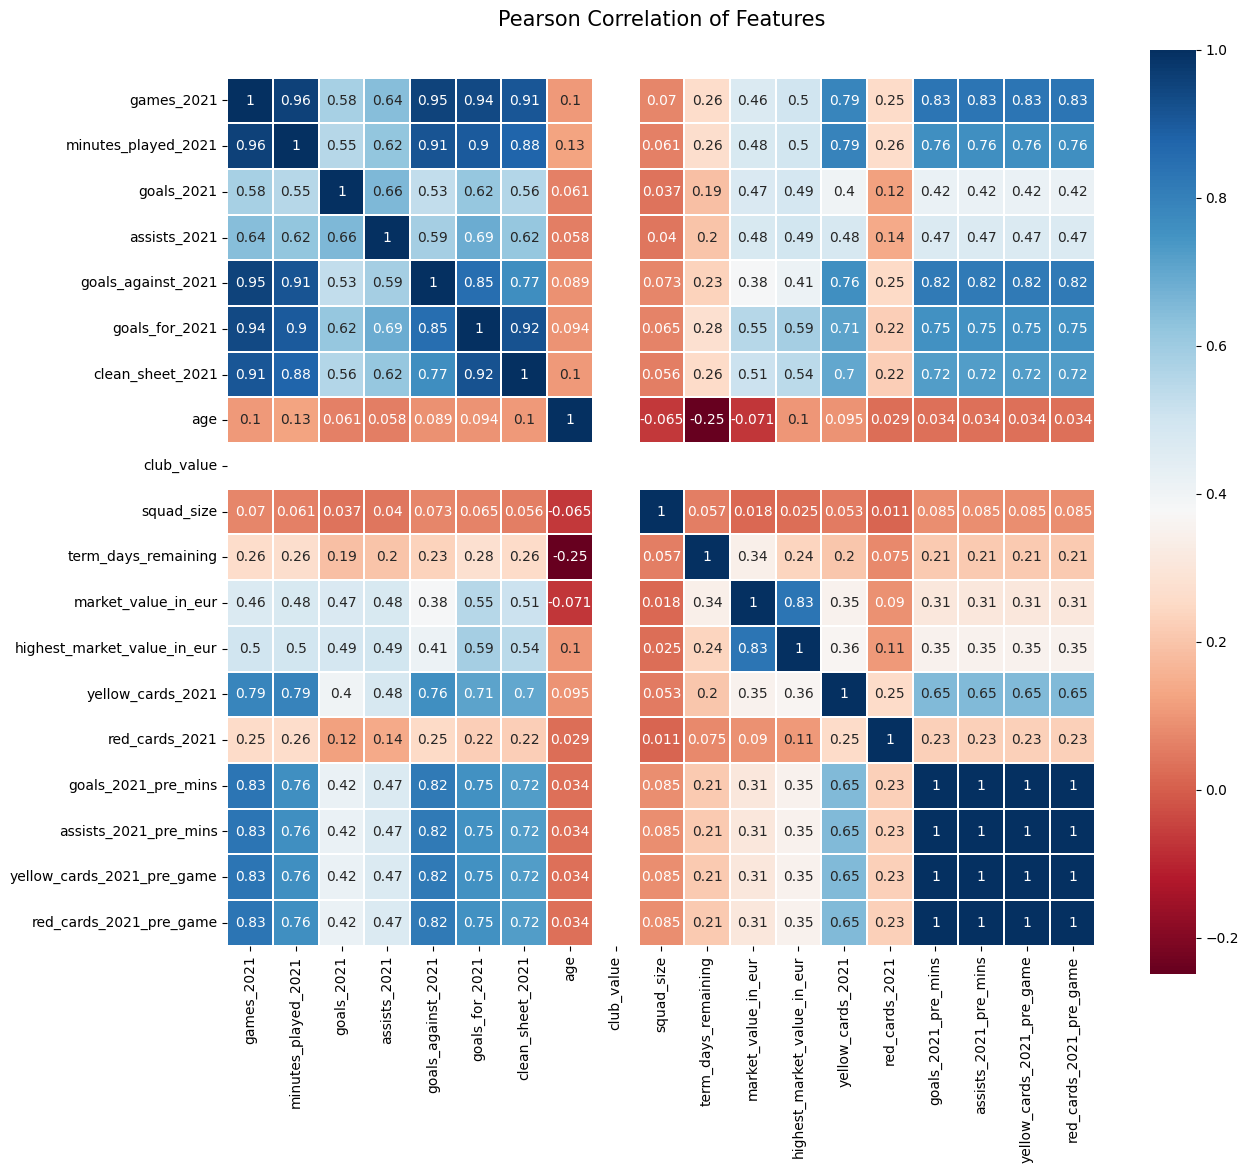

In [10]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
features_df=merged_players_df.drop(['player_id','name','position','sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date'],axis=1)
print(features_df.columns)
sns.heatmap(features_df.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

# Initial Feature Engineering

In [11]:
###### filter out only Gb players
leagues = ['GB1','FR1','L1','IT1','ES1']
labels = ['low','mid','high']
merged_players_df1 = merged_players_df[(merged_players_df.current_club_domestic_competition_id=='GB1')]
merged_players_df1['value_label'] = pd.cut(x = merged_players_df1['market_value_in_eur'],bins = [0,10000000,40000000,np.inf],labels = labels)

merged_players_df2 = merged_players_df[(merged_players_df.current_club_domestic_competition_id=='FR1')]
merged_players_df2['value_label'] = pd.cut(x = merged_players_df2['market_value_in_eur'],bins = [0,10000000,40000000,np.inf],labels = labels)

merged_players_df3 = merged_players_df[(merged_players_df.current_club_domestic_competition_id=='L1')]
merged_players_df3['value_label'] = pd.cut(x = merged_players_df3['market_value_in_eur'],bins = [0,10000000,40000000,np.inf],labels = labels)

merged_players_df4 = merged_players_df[(merged_players_df.current_club_domestic_competition_id=='IT1')]
merged_players_df4['value_label'] = pd.cut(x = merged_players_df4['market_value_in_eur'],bins = [0,10000000,40000000,np.inf],labels = labels)

merged_players_df5 = merged_players_df[(merged_players_df.current_club_domestic_competition_id=='ES1')]
merged_players_df5['value_label'] = pd.cut(x = merged_players_df5['market_value_in_eur'],bins = [0,10000000,40000000,np.inf],labels = labels)

merged_players_df6 = merged_players_df[(merged_players_df.current_club_domestic_competition_id.isin(leagues))]
merged_players_df6['value_label'] = pd.cut(x = merged_players_df6['market_value_in_eur'],bins = [0,10000000,40000000,np.inf],labels = labels)

# convert position categories to Columns for test data



dummies = pd.get_dummies(merged_players_df1[['position']], prefix_sep='_') #position
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1) 

dummies = pd.get_dummies(merged_players_df2[['position']], prefix_sep='_') #position
merged_players_df2 = pd.concat([merged_players_df2, dummies], axis=1) 

dummies = pd.get_dummies(merged_players_df3[['position']], prefix_sep='_') #position
merged_players_df3 = pd.concat([merged_players_df3, dummies], axis=1) 

dummies = pd.get_dummies(merged_players_df4[['position']], prefix_sep='_') #position
merged_players_df4 = pd.concat([merged_players_df4, dummies], axis=1) 

dummies = pd.get_dummies(merged_players_df5[['position']], prefix_sep='_') #position
merged_players_df5 = pd.concat([merged_players_df5, dummies], axis=1) 

dummies = pd.get_dummies(merged_players_df6[['position']], prefix_sep='_') #position
merged_players_df6 = pd.concat([merged_players_df6, dummies], axis=1) 
print('initial feature engineering complete') #print(merged_players_df1.head())

initial feature engineering complete


# Re-evaluate model

In [12]:
def ML_model_ANN1 (Input_Dimension_NN, DropoutRate, LearningRate):
    #Model struture is defined
    Inputs = tf.keras.Input(shape=(Input_Dimension_NN,), name="Input")
    X = tf.keras.layers.Dense(16, activation=tf.nn.sigmoid, name="Dense1") (Inputs)
    X = tf.keras.layers.Dropout(DropoutRate) (X)
    X = tf.keras.layers.Dense(8, activation=tf.nn.sigmoid, name="Dense2") (X)
    X = tf.keras.layers.Dropout(DropoutRate) (X)
#     X = tf.keras.layers.Dense(4, activation=tf.nn.sigmoid, name="Dense3") (X)
#     X = tf.keras.layers.Dropout(DropoutRate) (X)
    Output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name="Output") (X)
    #Output = tf.keras.layers.Dropout(DropoutRate) (X)
    model = tf.keras.Model(inputs=Inputs, outputs=Output)
    #Optimizer is defined
    Opt = tf.keras.optimizers.Adam(learning_rate=LearningRate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
    #Model is compiled
    model.compile(optimizer=Opt, loss='mae', metrics=['accuracy'])
    return model


def ML_model_ANN2():
    model = Sequential()
    model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1))
    #  编译模型
    model.compile(loss="mse", optimizer="Adam", metrics=["mae"])
    return model

#df6 ploting 

In [13]:
NUMERIC_COLUMNS=['goals_2021','goals_against_2021', 'goals_for_2021',
                 'games_2021','assists_2021','minutes_played_2021','age',
                 'squad_size','term_days_remaining','position_Attack',
                 'position_Defender','position_Goalkeeper','position_Midfield',
                 'goals_2021_pre_mins','assists_2021_pre_mins',
                 'yellow_cards_2021_pre_game','red_cards_2021_pre_game']

label: low model: LinearRegression() mape: 2.6385661376569844
label: low model: GradientBoostingRegressor() mape: 2.29845468403315
label: low model: SVR(gamma='auto') mape: 2.123597913698385
label: low model: DecisionTreeRegressor() mape: 2.281758434602677
label: low model: GradientBoostingRegressor() mape: 2.296788952448212
label: low model: RandomForestRegressor() mape: 2.2569984955694955
Learning rate set to 0.051239
0:	learn: 2233077.0248696	total: 2.73ms	remaining: 2.73s
1:	learn: 2188880.6348076	total: 4.8ms	remaining: 2.4s
2:	learn: 2147195.2965942	total: 6.97ms	remaining: 2.32s
3:	learn: 2107430.4288688	total: 9.1ms	remaining: 2.27s
4:	learn: 2071392.2191202	total: 11.1ms	remaining: 2.22s
5:	learn: 2037524.0265910	total: 13.2ms	remaining: 2.18s
6:	learn: 2007884.0748736	total: 15.1ms	remaining: 2.15s
7:	learn: 1979748.9631786	total: 17.3ms	remaining: 2.14s
8:	learn: 1950555.9605850	total: 19.2ms	remaining: 2.11s
9:	learn: 1923276.0431872	total: 21.3ms	remaining: 2.1s
10:	learn:

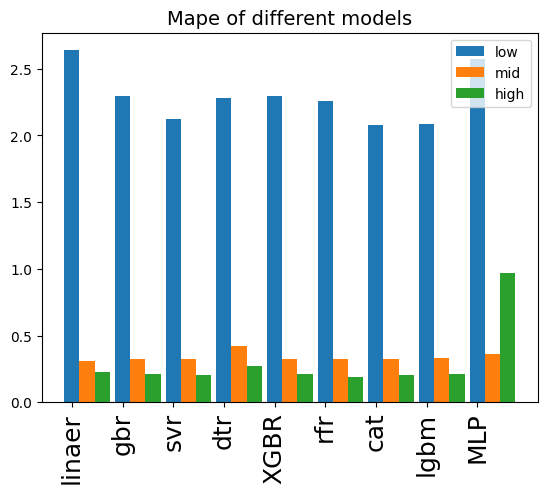

In [17]:
i=0

for label in labels: 
    mape=[]
    df = merged_players_df6[merged_players_df6['value_label'] == label]
    y = df['market_value_in_eur'].values
    X = df[NUMERIC_COLUMNS].fillna(-1000).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)

    #model data
    linear=LinearRegression()
    gbr = GradientBoostingRegressor()
    svr = SVR(kernel="rbf",gamma="auto")
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    XGBR = ensemble.GradientBoostingRegressor()
    cat= CatBoostRegressor()
    lgbm=LGBMRegressor()
    ANN_model = ML_model_ANN2()
    models=[linear,gbr,svr,dtr,XGBR,rfr,cat,lgbm,ANN_model]
    for model in models:
        if model==ANN_model:
            scaler_X_train = MinMaxScaler(feature_range=(0, 1))
            X_train = scaler_X_train.fit_transform(X_train)

            scaler_X_test = MinMaxScaler(feature_range=(0, 1))
            X_test = scaler_X_test.fit_transform(X_test)
            model.fit(X_train,y_train,epochs = 1000,verbose = 0,batch_size = 64)
            prediction = model.predict(X_test).reshape(-1,)
            mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
            print('label:',label,'model:',model,'mape:',mape[-1])
            break
        model.fit(X_train, y_train)
        #assess accurancy of model
        prediction = model.predict(X_test).reshape(-1,)
        
        mape.append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
        print('label:',label,'model:',model,'mape:',mape[-1])
    #create barchart to show performances
    # 有a/b/c三种类型的数据，n设置为3
    total_width, n = 0.9, 3
    # 每种类型的柱状图宽度
    width = total_width / n
    x = np.arange(len(models))
    y = mape
    plt.bar(x+i*width,y,width=width,label=label)
    i+=1
model_lable=['linaer','gbr','svr','dtr','XGBR','rfr','cat','lgbm','MLP']
plt.legend()   
plt.xticks(fontsize=18, rotation=90)
plt.xticks(x, model_lable)
plt.title('Mape of different models',fontsize=14)
plt.show()

# **DF without zero games played in 2022**

label: low model: LinearRegression() mape: 0.959738801424934
label: low model: GradientBoostingRegressor() mape: 0.8759199621996308
label: low model: SVR(gamma='auto') mape: 1.1012647593116196
label: low model: DecisionTreeRegressor() mape: 1.1148810185645592
label: low model: GradientBoostingRegressor() mape: 0.8729741775045284
label: low model: RandomForestRegressor() mape: 0.8766225950778525
Learning rate set to 0.0422
0:	learn: 2824093.7003012	total: 2.19ms	remaining: 2.19s
1:	learn: 2789715.5454089	total: 3.58ms	remaining: 1.79s
2:	learn: 2755980.9505931	total: 5ms	remaining: 1.66s
3:	learn: 2728246.3036652	total: 6.36ms	remaining: 1.58s
4:	learn: 2699845.7938245	total: 7.66ms	remaining: 1.52s
5:	learn: 2672753.1529471	total: 8.94ms	remaining: 1.48s
6:	learn: 2651345.1560145	total: 10.1ms	remaining: 1.43s
7:	learn: 2628495.7716903	total: 11.2ms	remaining: 1.39s
8:	learn: 2604941.3099799	total: 12.4ms	remaining: 1.37s
9:	learn: 2580434.9939600	total: 13.5ms	remaining: 1.34s
10:	lea

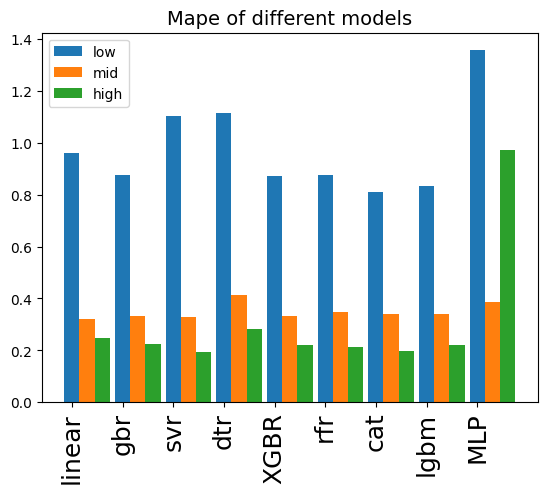

In [26]:
i=0

for label in labels: 
    mape=[]
    df = merged_players_df6[merged_players_df6['value_label'] == label]
    df=df[df['games_2021']!=0]
    y = df['market_value_in_eur'].values
    X = df[NUMERIC_COLUMNS].fillna(-1000).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)

    #model data
    linear=LinearRegression()
    gbr = GradientBoostingRegressor()
    svr = SVR(kernel="rbf",gamma="auto")
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    XGBR = ensemble.GradientBoostingRegressor()
    cat= CatBoostRegressor()
    lgbm=LGBMRegressor()
    ANN_model = ML_model_ANN2()
    models=[linear,gbr,svr,dtr,XGBR,rfr,cat,lgbm,ANN_model]
    for model in models:
        if model==ANN_model:
            scaler_X_train = MinMaxScaler(feature_range=(0, 1))
            X_train = scaler_X_train.fit_transform(X_train)

            scaler_X_test = MinMaxScaler(feature_range=(0, 1))
            X_test = scaler_X_test.fit_transform(X_test)
            model.fit(X_train,y_train,epochs = 1000,verbose = 0,batch_size = 64)
            prediction = model.predict(X_test).reshape(-1,)
            mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
            print('label:',label,'model:',model,'mape:',mape[-1])

            break
        model.fit(X_train, y_train)
        #assess accurancy of model
        prediction = model.predict(X_test).reshape(-1,)
        mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
        print('label:',label,'model:',model,'mape:',mape[-1])
    #create barchart to show performances
    # 有a/b/c三种类型的数据，n设置为3
    total_width, n = 0.9, 3
    # 每种类型的柱状图宽度
    width = total_width / n
    x = np.arange(len(models))
    y = mape
    plt.bar(x+i*width,y,width=width,label=label)
    i+=1
model_lable=['linear','gbr','svr','dtr','XGBR','rfr','cat','lgbm','MLP']
plt.legend()   
plt.xticks(fontsize=18, rotation=90)
plt.xticks(x, model_lable)
plt.title('Mape of different models',fontsize=14)
plt.show()

In [14]:
NUMERIC_COLUMNS=['goals_2021','goals_against_2021', 'goals_for_2021',
                 'games_2021','assists_2021','minutes_played_2021','age',
                 'squad_size','term_days_remaining','position_Attack',
                 'position_Defender','position_Goalkeeper','position_Midfield',
                 'goals_2021_pre_mins','assists_2021_pre_mins',
                 'yellow_cards_2021_pre_game','red_cards_2021_pre_game']

# **leagues = ['GB1','FR1','L1','IT1','ES1'] PLOT**

GB1

Learning rate set to 0.031253
0:	learn: 3022981.6102769	total: 56.5ms	remaining: 56.4s
1:	learn: 2995548.5280102	total: 57.3ms	remaining: 28.6s
2:	learn: 2968831.1874167	total: 58.1ms	remaining: 19.3s
3:	learn: 2940313.1397332	total: 58.8ms	remaining: 14.6s
4:	learn: 2913958.1388369	total: 59.5ms	remaining: 11.8s
5:	learn: 2890170.0795050	total: 60.2ms	remaining: 9.97s
6:	learn: 2872662.6689866	total: 60.9ms	remaining: 8.63s
7:	learn: 2845998.6748184	total: 61.5ms	remaining: 7.63s
8:	learn: 2821684.8814310	total: 63ms	remaining: 6.94s
9:	learn: 2795876.2662602	total: 63.7ms	remaining: 6.31s
10:	learn: 2776861.7634765	total: 64.4ms	remaining: 5.79s
11:	learn: 2758795.0395465	total: 65.1ms	remaining: 5.36s
12:	learn: 2743643.1525873	total: 65.7ms	remaining: 4.99s
13:	learn: 2729449.2355485	total: 66.4ms	remaining: 4.67s
14:	learn: 2707417.3361462	total: 67.1ms	remaining: 4.4s
15:	learn: 2685583.4394133	total: 67.7ms	remaining: 4.16s
16:	learn: 2664795.8312980	total: 68.4ms	remaining: 3.9

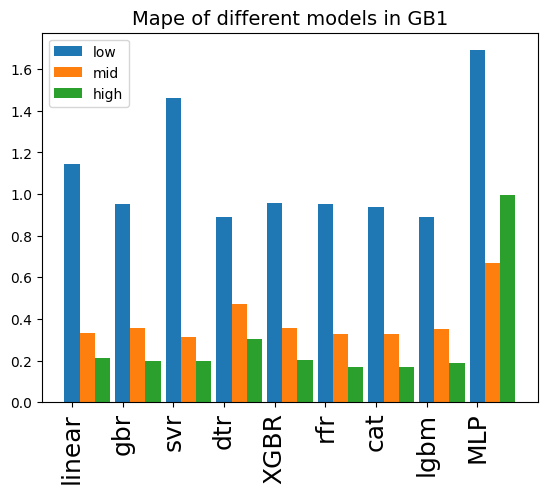

In [15]:
i=0

for label in labels: 
    mape=[]
    df = merged_players_df1[merged_players_df1['value_label'] == label]
    df=df[df['games_2021']!=0]
    y = df['market_value_in_eur'].values
    X = df[NUMERIC_COLUMNS].fillna(0).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)

    #model data
    linear=LinearRegression()
    gbr = GradientBoostingRegressor()
    svr = SVR(kernel="rbf",gamma="auto")
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    XGBR = ensemble.GradientBoostingRegressor()
    cat= CatBoostRegressor()
    lgbm=LGBMRegressor()
    ANN_model = ML_model_ANN2()
    models=[linear,gbr,svr,dtr,XGBR,rfr,cat,lgbm,ANN_model]
    for model in models:
        if model==ANN_model:
            scaler_X_train = MinMaxScaler(feature_range=(0, 1))
            X_train = scaler_X_train.fit_transform(X_train)

            scaler_X_test = MinMaxScaler(feature_range=(0, 1))
            X_test = scaler_X_test.fit_transform(X_test)
            model.fit(X_train,y_train,epochs = 1000,verbose = 0,batch_size = 64)
            prediction = model.predict(X_test).reshape(-1,)
            mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
            #print('label:',label,'model:',model,'mape:',mape[-1])

            break
        model.fit(X_train, y_train)
        #assess accurancy of model
        prediction = model.predict(X_test).reshape(-1,)
        mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
        #print('label:',label,'model:',model,'mape:',mape[-1])
    #create barchart to show performances
    # 有a/b/c三种类型的数据，n设置为3
    total_width, n = 0.9, 3
    # 每种类型的柱状图宽度
    width = total_width / n
    x = np.arange(len(models))
    y = mape
    plt.bar(x+i*width,y,width=width,label=label)
    i+=1
model_lable=['linear','gbr','svr','dtr','XGBR','rfr','cat','lgbm','MLP']
plt.legend()   
plt.xticks(fontsize=18, rotation=90)
plt.xticks(x, model_lable)
plt.title('Mape of different models in GB1',fontsize=14)
plt.show()

FR1

Learning rate set to 0.032931
0:	learn: 2835420.8744676	total: 2.29ms	remaining: 2.28s
1:	learn: 2815149.6844293	total: 3.31ms	remaining: 1.65s
2:	learn: 2787842.1747328	total: 4.18ms	remaining: 1.39s
3:	learn: 2758701.8291470	total: 5.15ms	remaining: 1.28s
4:	learn: 2739206.6679005	total: 5.91ms	remaining: 1.18s
5:	learn: 2711521.9250600	total: 6.56ms	remaining: 1.09s
6:	learn: 2687819.3021366	total: 7.25ms	remaining: 1.03s
7:	learn: 2662674.2621534	total: 7.93ms	remaining: 983ms
8:	learn: 2633404.0273143	total: 8.61ms	remaining: 948ms
9:	learn: 2611279.9249031	total: 9.28ms	remaining: 918ms
10:	learn: 2583356.2121990	total: 10ms	remaining: 900ms
11:	learn: 2560553.0976338	total: 10.7ms	remaining: 881ms
12:	learn: 2541919.9863747	total: 11.4ms	remaining: 866ms
13:	learn: 2524830.9014258	total: 12.1ms	remaining: 854ms
14:	learn: 2503178.1674327	total: 12.8ms	remaining: 840ms
15:	learn: 2485005.1822967	total: 13.5ms	remaining: 830ms
16:	learn: 2461978.1731770	total: 14.1ms	remaining: 81

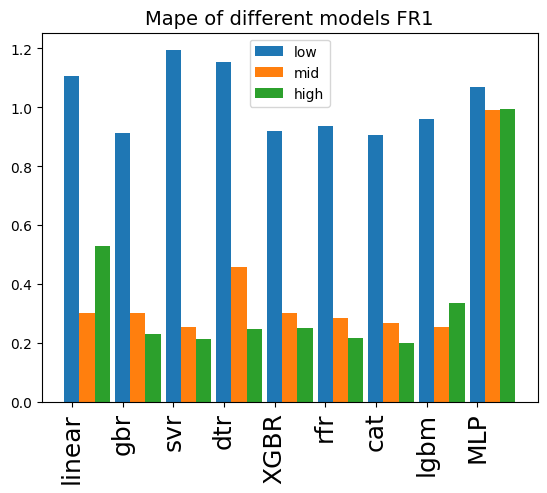

In [18]:
i=0

for label in labels: 
    mape=[]
    df = merged_players_df2[merged_players_df2['value_label'] == label]
    df=df[df['games_2021']!=0]
    y = df['market_value_in_eur'].values
    X = df[NUMERIC_COLUMNS].fillna(0).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    #model data
    linear=LinearRegression()
    gbr = GradientBoostingRegressor()
    svr = SVR(kernel="rbf",gamma="auto")
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    XGBR = ensemble.GradientBoostingRegressor()
    cat= CatBoostRegressor()
    lgbm=LGBMRegressor()
    ANN_model = ML_model_ANN2()
    models=[linear,gbr,svr,dtr,XGBR,rfr,cat,lgbm,ANN_model]
    for model in models:
        if model==ANN_model:
            scaler_X_train = MinMaxScaler(feature_range=(0, 1))
            X_train = scaler_X_train.fit_transform(X_train)

            scaler_X_test = MinMaxScaler(feature_range=(0, 1))
            X_test = scaler_X_test.fit_transform(X_test)
            model.fit(X_train,y_train,epochs = 1000,verbose = 0,batch_size = 64)
            prediction = model.predict(X_test).reshape(-1,)
            mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
            #print('label:',label,'model:',model,'mape:',mape[-1])

            break
        model.fit(X_train, y_train)
        #assess accurancy of model
        prediction = model.predict(X_test).reshape(-1,)
        mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
        #print('label:',label,'model:',model,'mape:',mape[-1])
    #create barchart to show performances
    # 有a/b/c三种类型的数据，n设置为3
    total_width, n = 0.9, 3
    # 每种类型的柱状图宽度
    width = total_width / n
    x = np.arange(len(models))
    y = mape
    plt.bar(x+i*width,y,width=width,label=label)
    i+=1
model_lable=['linear','gbr','svr','dtr','XGBR','rfr','cat','lgbm','MLP']
plt.legend()   
plt.xticks(fontsize=18, rotation=90)
plt.xticks(x, model_lable)
plt.title('Mape of different models FR1',fontsize=14)
plt.show()

L1

Learning rate set to 0.032481
0:	learn: 2666630.3953084	total: 961us	remaining: 960ms
1:	learn: 2641448.0967963	total: 1.81ms	remaining: 901ms
2:	learn: 2613018.6390005	total: 2.76ms	remaining: 916ms
3:	learn: 2588489.4102271	total: 3.5ms	remaining: 872ms
4:	learn: 2565751.7074938	total: 4.24ms	remaining: 844ms
5:	learn: 2538042.6100725	total: 5.19ms	remaining: 859ms
6:	learn: 2521947.4184669	total: 5.72ms	remaining: 812ms
7:	learn: 2498502.3843263	total: 6.6ms	remaining: 818ms
8:	learn: 2475512.9868066	total: 7.54ms	remaining: 831ms
9:	learn: 2459092.5587823	total: 8.32ms	remaining: 823ms
10:	learn: 2439177.4215739	total: 9.09ms	remaining: 818ms
11:	learn: 2418196.0103961	total: 9.88ms	remaining: 813ms
12:	learn: 2394006.4079053	total: 10.7ms	remaining: 814ms
13:	learn: 2378922.7563733	total: 11.5ms	remaining: 808ms
14:	learn: 2357948.0102689	total: 12.2ms	remaining: 801ms
15:	learn: 2337752.4322735	total: 12.9ms	remaining: 793ms
16:	learn: 2316198.8087105	total: 13.7ms	remaining: 789

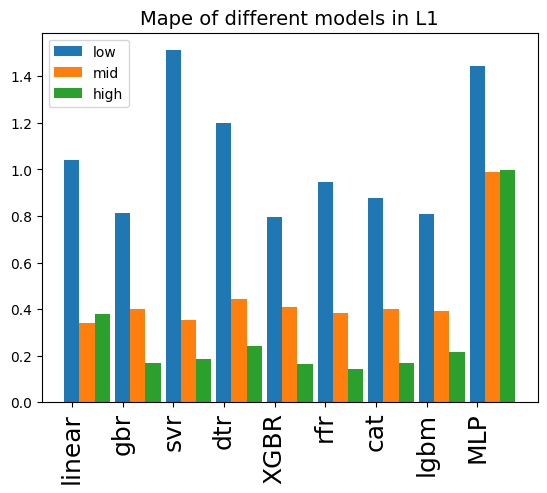

In [19]:
i=0

for label in labels: 
    mape=[]
    df = merged_players_df3[merged_players_df3['value_label'] == label]
    df=df[df['games_2021']!=0]
    y = df['market_value_in_eur'].values
    X = df[NUMERIC_COLUMNS].fillna(0).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)

    #model data
    linear=LinearRegression()
    gbr = GradientBoostingRegressor()
    svr = SVR(kernel="rbf",gamma="auto")
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    XGBR = ensemble.GradientBoostingRegressor()
    cat= CatBoostRegressor()
    lgbm=LGBMRegressor()
    ANN_model = ML_model_ANN2()
    models=[linear,gbr,svr,dtr,XGBR,rfr,cat,lgbm,ANN_model]
    for model in models:
        if model==ANN_model:
            scaler_X_train = MinMaxScaler(feature_range=(0, 1))
            X_train = scaler_X_train.fit_transform(X_train)

            scaler_X_test = MinMaxScaler(feature_range=(0, 1))
            X_test = scaler_X_test.fit_transform(X_test)
            model.fit(X_train,y_train,epochs = 1000,verbose = 0,batch_size = 64)
            prediction = model.predict(X_test).reshape(-1,)
            mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
            print('label:',label,'model:',model,'mape:',mape[-1])

            break
        model.fit(X_train, y_train)
        #assess accurancy of model
        prediction = model.predict(X_test).reshape(-1,)
        mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
        #print('label:',label,'model:',model,'mape:',mape[-1])
    #create barchart to show performances
    # 有a/b/c三种类型的数据，n设置为3
    total_width, n = 0.9, 3
    # 每种类型的柱状图宽度
    width = total_width / n
    x = np.arange(len(models))
    y = mape
    plt.bar(x+i*width,y,width=width,label=label)
    i+=1
model_lable=['linear','gbr','svr','dtr','XGBR','rfr','cat','lgbm','MLP']
plt.legend()   
plt.xticks(fontsize=18, rotation=90)
plt.xticks(x, model_lable)
plt.title('Mape of different models in L1',fontsize=14)
plt.show()

IT1

Learning rate set to 0.033446
0:	learn: 2759698.6335740	total: 1.13ms	remaining: 1.13s
1:	learn: 2736247.3164350	total: 2.27ms	remaining: 1.14s
2:	learn: 2703969.6841922	total: 3.42ms	remaining: 1.14s
3:	learn: 2669152.4018691	total: 4.35ms	remaining: 1.08s
4:	learn: 2642328.1623231	total: 5.23ms	remaining: 1.04s
5:	learn: 2617466.7544652	total: 6.15ms	remaining: 1.02s
6:	learn: 2601618.8489444	total: 6.81ms	remaining: 966ms
7:	learn: 2575591.8014583	total: 7.7ms	remaining: 954ms
8:	learn: 2550315.5887828	total: 8.43ms	remaining: 928ms
9:	learn: 2524569.9560010	total: 9.1ms	remaining: 901ms
10:	learn: 2503840.0588039	total: 9.8ms	remaining: 881ms
11:	learn: 2475959.3532845	total: 10.5ms	remaining: 865ms
12:	learn: 2458128.1885138	total: 11.2ms	remaining: 847ms
13:	learn: 2444967.0739541	total: 11.8ms	remaining: 835ms
14:	learn: 2421137.1179156	total: 12.5ms	remaining: 823ms
15:	learn: 2406535.5338845	total: 13.2ms	remaining: 813ms
16:	learn: 2386610.4081254	total: 13.9ms	remaining: 805

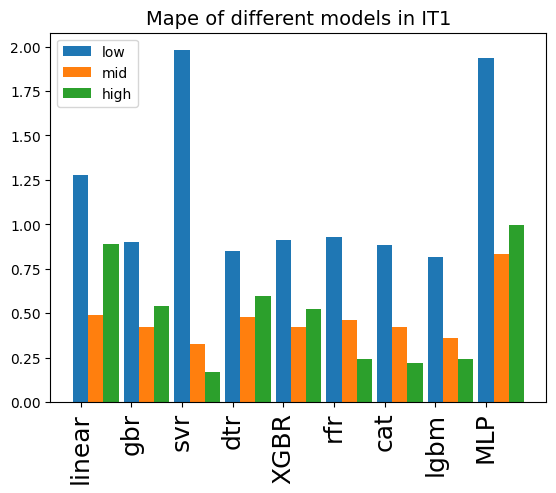

In [20]:
i=0

for label in labels: 
    mape=[]
    df = merged_players_df4[merged_players_df4['value_label'] == label]
    df=df[df['games_2021']!=0]
    y = df['market_value_in_eur'].values
    X = df[NUMERIC_COLUMNS].fillna(0).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)

    #model data
    linear=LinearRegression()
    gbr = GradientBoostingRegressor()
    svr = SVR(kernel="rbf",gamma="auto")
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    XGBR = ensemble.GradientBoostingRegressor()
    cat= CatBoostRegressor()
    lgbm=LGBMRegressor()
    ANN_model = ML_model_ANN2()
    models=[linear,gbr,svr,dtr,XGBR,rfr,cat,lgbm,ANN_model]
    for model in models:
        if model==ANN_model:
            scaler_X_train = MinMaxScaler(feature_range=(0, 1))
            X_train = scaler_X_train.fit_transform(X_train)

            scaler_X_test = MinMaxScaler(feature_range=(0, 1))
            X_test = scaler_X_test.fit_transform(X_test)
            model.fit(X_train,y_train,epochs = 1000,verbose = 0,batch_size = 64)
            prediction = model.predict(X_test).reshape(-1,)
            mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
            print('label:',label,'model:',model,'mape:',mape[-1])

            break
        model.fit(X_train, y_train)
        #assess accurancy of model
        prediction = model.predict(X_test).reshape(-1,)
        mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
        #print('label:',label,'model:',model,'mape:',mape[-1])
    #create barchart to show performances
    # 有a/b/c三种类型的数据，n设置为3
    total_width, n = 0.9, 3
    # 每种类型的柱状图宽度
    width = total_width / n
    x = np.arange(len(models))
    y = mape
    plt.bar(x+i*width,y,width=width,label=label)
    i+=1
model_lable=['linear','gbr','svr','dtr','XGBR','rfr','cat','lgbm','MLP']
plt.legend()   
plt.xticks(fontsize=18, rotation=90)
plt.xticks(x, model_lable)
plt.title('Mape of different models in IT1',fontsize=14)
plt.show()

ES1

Learning rate set to 0.033233
0:	learn: 2595932.9151274	total: 1.05ms	remaining: 1.05s
1:	learn: 2580428.8546814	total: 1.99ms	remaining: 993ms
2:	learn: 2558399.9548122	total: 2.97ms	remaining: 988ms
3:	learn: 2531412.4995552	total: 3.95ms	remaining: 983ms
4:	learn: 2510471.8833241	total: 4.78ms	remaining: 952ms
5:	learn: 2489102.4855994	total: 5.85ms	remaining: 970ms
6:	learn: 2475133.3609104	total: 6.71ms	remaining: 951ms
7:	learn: 2453641.3237238	total: 7.67ms	remaining: 951ms
8:	learn: 2435237.2176754	total: 8.52ms	remaining: 938ms
9:	learn: 2416934.9549412	total: 9.56ms	remaining: 946ms
10:	learn: 2398873.2504448	total: 10.5ms	remaining: 946ms
11:	learn: 2380461.0014312	total: 11.5ms	remaining: 945ms
12:	learn: 2364664.5490007	total: 12.3ms	remaining: 934ms
13:	learn: 2349014.2968897	total: 13.3ms	remaining: 934ms
14:	learn: 2333471.3086052	total: 14ms	remaining: 921ms
15:	learn: 2319050.0627420	total: 14.8ms	remaining: 907ms
16:	learn: 2302449.0752789	total: 15.5ms	remaining: 89

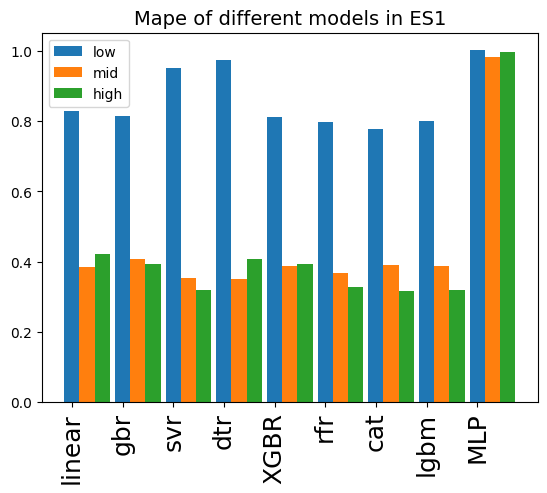

In [21]:
i=0

for label in labels: 
    mape=[]
    df = merged_players_df5[merged_players_df5['value_label'] == label]
    df=df[df['games_2021']!=0]
    y = df['market_value_in_eur'].values
    X = df[NUMERIC_COLUMNS].fillna(0).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)

    #model data
    linear=LinearRegression()
    gbr = GradientBoostingRegressor()
    svr = SVR(kernel="rbf",gamma="auto")
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    XGBR = ensemble.GradientBoostingRegressor()
    cat= CatBoostRegressor()
    lgbm=LGBMRegressor()
    ANN_model = ML_model_ANN2()
    models=[linear,gbr,svr,dtr,XGBR,rfr,cat,lgbm,ANN_model]
    for model in models:
        if model==ANN_model:
            scaler_X_train = MinMaxScaler(feature_range=(0, 1))
            X_train = scaler_X_train.fit_transform(X_train)

            scaler_X_test = MinMaxScaler(feature_range=(0, 1))
            X_test = scaler_X_test.fit_transform(X_test)
            model.fit(X_train,y_train,epochs = 1000,verbose = 0,batch_size = 64)
            prediction = model.predict(X_test).reshape(-1,)
            mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
            print('label:',label,'model:',model,'mape:',mape[-1])

            break
        model.fit(X_train, y_train)
        #assess accurancy of model
        prediction = model.predict(X_test).reshape(-1,)
        mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
        #print('label:',label,'model:',model,'mape:',mape[-1])
    #create barchart to show performances
    # 有a/b/c三种类型的数据，n设置为3
    total_width, n = 0.9, 3
    # 每种类型的柱状图宽度
    width = total_width / n
    x = np.arange(len(models))
    y = mape
    plt.bar(x+i*width,y,width=width,label=label)
    i+=1
model_lable=['linear','gbr','svr','dtr','XGBR','rfr','cat','lgbm','MLP']
plt.legend()   
plt.xticks(fontsize=18, rotation=90)
plt.xticks(x, model_lable)
plt.title('Mape of different models in ES1',fontsize=14)
plt.show()

# no lable without zero games and baseline

In [14]:
from sklearn.linear_model import LinearRegression


label: high model: LinearRegression() mape: 2.43533975437796
label: high model: GradientBoostingRegressor(random_state=0) mape: 1.1333129885942053
label: high model: SVR(gamma='auto', kernel='linear') mape: 1.3786564362823306
label: high model: DecisionTreeRegressor(random_state=0) mape: 1.2426403259087508
label: high model: GradientBoostingRegressor(learning_rate=0.04, n_estimators=1000, random_state=1) mape: 1.155155554559668
label: high model: RandomForestRegressor(random_state=1) mape: 1.1622824915861014
0:	learn: 13263433.7204414	total: 964us	remaining: 8.68ms
1:	learn: 12446631.0916992	total: 1.71ms	remaining: 6.85ms
2:	learn: 11700262.8908665	total: 2.44ms	remaining: 5.68ms
3:	learn: 11423491.7205848	total: 3.09ms	remaining: 4.64ms
4:	learn: 11128701.7701179	total: 3.85ms	remaining: 3.85ms
5:	learn: 10820685.9993604	total: 4.56ms	remaining: 3.04ms
6:	learn: 10718868.5668656	total: 5.24ms	remaining: 2.24ms
7:	learn: 10562275.1062662	total: 6.03ms	remaining: 1.51ms
8:	learn: 10443

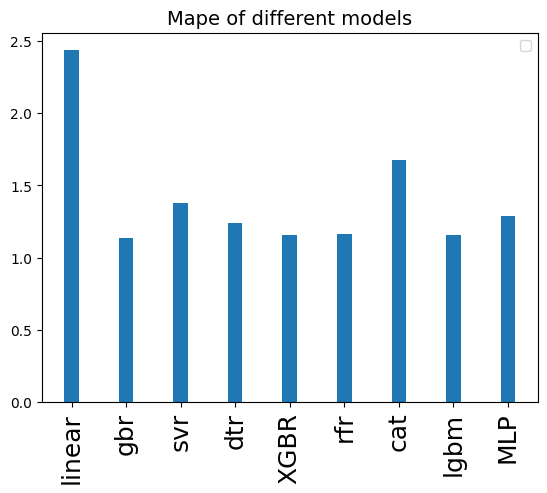

In [22]:
mape=[]
df = merged_players_df6
df=df[df['games_2021']!=0]
y = df['market_value_in_eur'].values
X = df[NUMERIC_COLUMNS].fillna(0).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)

#model data
linear=LinearRegression()
gbr = GradientBoostingRegressor(random_state=0)
svr = SVR(kernel="linear",gamma="auto")
dtr = DecisionTreeRegressor(random_state=0)
rfr = RandomForestRegressor(random_state=1)
XGBR = ensemble.GradientBoostingRegressor(n_estimators=1000, learning_rate=0.04, random_state=1)
cat= CatBoostRegressor(iterations=10,learning_rate=1,depth=3)
lgbm=LGBMRegressor()
ANN_model = ML_model_ANN2()
models=[linear,gbr,svr,dtr,XGBR,rfr,cat,lgbm,ANN_model]
for model in models:
    if model==ANN_model:
        scaler_X_train = MinMaxScaler(feature_range=(0, 1))
        X_train = scaler_X_train.fit_transform(X_train)

        scaler_X_test = MinMaxScaler(feature_range=(0, 1))
        X_test = scaler_X_test.fit_transform(X_test)
        model.fit(X_train,y_train,epochs = 1000,verbose = 0,batch_size = 64)
        prediction = model.predict(X_test).reshape(-1,)
        mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
        print('label:',label,'model:',model,'mape:',mape[-1])
        break
        
    model.fit(X_train, y_train)
    #assess accurancy of model
    prediction = model.predict(X_test).reshape(-1,)
    mape .append(np.sum(np.absolute((y_test - prediction)/y_test))/prediction.shape[0])
    print('label:',label,'model:',model,'mape:',mape[-1])
    #create barchart to show performances
# 有a/b/c三种类型的数据，n设置为3
total_width, n = 0.8, 3
# 每种类型的柱状图宽度
width = total_width / n
x = np.arange(len(models))
y = mape
plt.bar(x,y,width=width)

model_lable=['linear','gbr','svr','dtr','XGBR','rfr','cat','lgbm','MLP']
plt.legend()   
plt.xticks(fontsize=18, rotation=90)
plt.xticks(x, model_lable)
plt.title('Mape of different models',fontsize=14)
plt.show()